# Image Generation using LSTM
    how to generate images using an LSTM with the MNIST dataset:

### RNN vs LSTM vs GRU
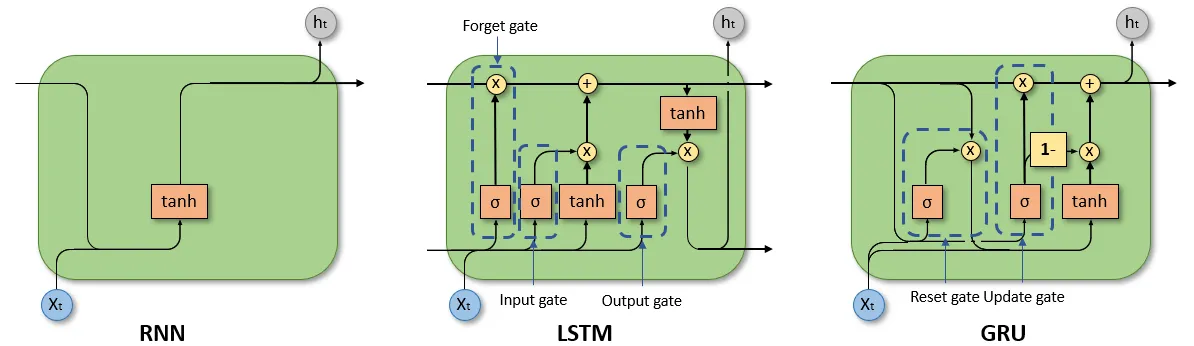
    LSTM and GRU are variants of RNNs that include additional structures to better capture long-term dependencies.

## LSTM (Long Short-Term Memory)

https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

    torch.nn.LSTM(input_size, hidden_size, num_layers=1, bias=True, batch_first=False, dropout=0.0, bidirectional=False, proj_size=0, device=None, dtype=None)

> ### Parameters
> - input_size – The number of expected features in the input x
> - hidden_size – The number of features in the hidden state h
> - num_layers – Number of recurrent layers. Default: 1 
> - bias – If False, then the layer does not use bias weights b_ih and b_hh. Default: True
> - batch_first – If True, then the input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature). Default: False
> - dropout – If non-zero, introduces a Dropout layer on the outputs of each RNN layer except the last layer. Default: 0
> - bidirectional – If True, becomes a bidirectional RNN. Default: False

   - **Input Gate**: Determines how much of the new information should be added to the cell state.
   - **Forget Gate**: Decides how much of the previous cell state should be kept.
   - **Output Gate**: Controls the output and the amount of cell state to be passed to the next hidden state.


### LSTM unit
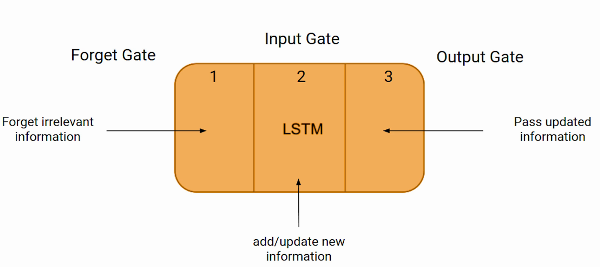

## Hidden and Cell States
- Hidden State (h_t): Short-term memory that is used for output at each time step.
- Cell State (c_t): Long-term memory that carries information across many time steps.
  
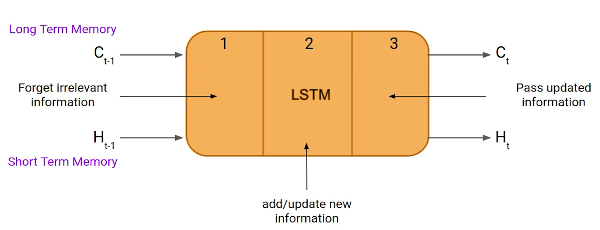

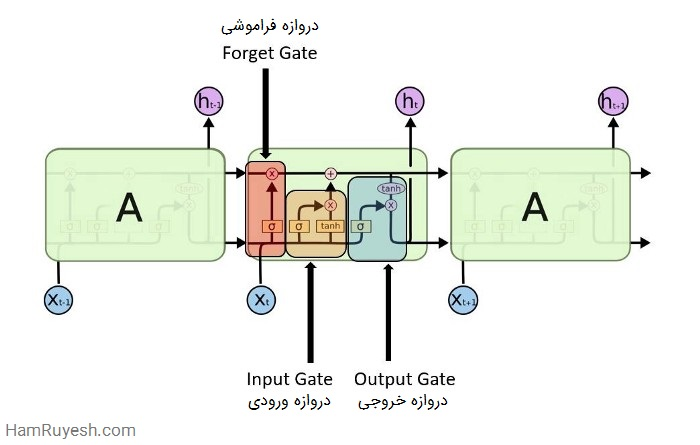

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

## Generate images using an LSTM with the MNIST dataset: 

In [3]:
#  Load the Data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])
# Load the MNIST dataset
#  The MNIST database (Modified National Institute of Standards and Technology database)
# is a large collection of handwritten digits. 
# It has a training set of 60,000 examples, and a test set of 10,000 examples.
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [4]:
# Set device to GPU if available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        
        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        
        # Define a fully connected layer that maps from hidden state space to output space
        self.fc = nn.Linear(hidden_size, output_size)
        
        # Save hidden_size and num_layers for use in init_hidden
        self.hidden_size = hidden_size
        self.num_layers = num_layers

    def forward(self, x, hidden=None):
        # Forward pass through the LSTM layer
        out, hidden = self.lstm(x, hidden)
        
        # Apply the fully connected layer to each time step in the output sequence
        out = self.fc(out)
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        # Initialize both hidden state and cell state to zeros
        # Shape: (num_layers, batch_size, hidden_size)
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device),
                torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device))


In [53]:
# Model parameters
input_size = 28  # Each pixel in the row
hidden_size = 100
output_size = 28  # Each pixel in the row
num_layers = 1  # Number of LSTM layers

# Instantiate the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, output_size, num_layers).to(device)
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    for inputs, _ in train_loader:
        inputs = inputs.squeeze(1).to(device)  # Remove channel dimension and move to device
        optimizer.zero_grad()  # Zero the parameter gradients
        loss = 0
        
        # Initialize hidden state for this batch
        hidden = model.init_hidden(inputs.size(0))
        
        # Loop over each row in the input sequence
        for i in range(1, 28):  # Start from the second row to predict from the first row
            output, hidden = model(inputs[:, i-1:i, :], hidden)  # Forward pass
            loss += criterion(output.squeeze(), inputs[:, i, :])  # Calculate loss
        
        loss.backward()  # Backward pass
        optimizer.step()  # Update parameters
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/20], Loss: 3.1968
Epoch [2/20], Loss: 1.9835
Epoch [3/20], Loss: 1.8017
Epoch [4/20], Loss: 1.6932
Epoch [5/20], Loss: 1.6212
Epoch [6/20], Loss: 1.5706
Epoch [7/20], Loss: 1.5319
Epoch [8/20], Loss: 1.5013
Epoch [9/20], Loss: 1.4759
Epoch [10/20], Loss: 1.4537
Epoch [11/20], Loss: 1.4367
Epoch [12/20], Loss: 1.4201
Epoch [13/20], Loss: 1.4063
Epoch [14/20], Loss: 1.3945
Epoch [15/20], Loss: 1.3836
Epoch [16/20], Loss: 1.3744
Epoch [17/20], Loss: 1.3654
Epoch [18/20], Loss: 1.3582
Epoch [19/20], Loss: 1.3512
Epoch [20/20], Loss: 1.3430


In [54]:
# Function to generate a new image
def generate_image(start_row, model):
    model.eval()  # Set model to evaluation mode
    generated_image = [start_row.cpu().numpy()]  # Initialize generated image with the start row
    
    # Prepare the input row for the model (add batch and sequence dimensions)
    input_row = start_row.unsqueeze(0).unsqueeze(0).to(device)
    
    # Initialize hidden state for generation
    hidden = model.init_hidden(1)  # Batch size is 1 for generation
    
    with torch.no_grad():  # No need to calculate gradients during inference
        for _ in range(27):  # Generate 27 more rows
            output, hidden = model(input_row, hidden)  # Forward pass
            input_row = output  # Use the output as the next input
            generated_image.append(output.squeeze().cpu().numpy())  # Append the output row to the generated image
    
    return np.vstack(generated_image)  # Stack rows to form the complete image

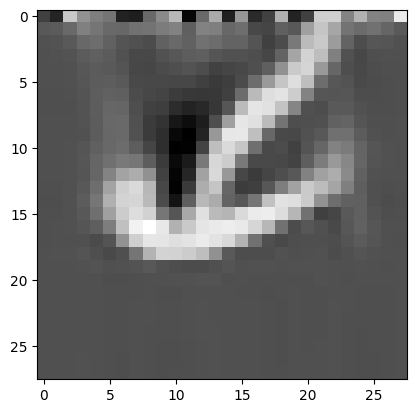

In [60]:
# Generate a new image
start_row = torch.randn(28).to(device)  # Randomly initialize the first row
generated_image = generate_image(start_row, model)

# Plot the generated image
plt.imshow(generated_image, cmap='gray')
plt.show()


In [61]:
torch.save(model, 'lstm_image_generation_model.pth')

In [62]:
# model=torch.load('lstm_image_generation_model.pth')